# 1. LIBRERÍAS

Librerías más destacadas y su función en este notebook:

* `glob`: para trabajar con ficheros

* `os` y `os.path`: para operaciones con ficheros

* `pytorch`: para trabajar con tensores, estructuras de ML...


* `numpy`: para trabajar con estructuras matemáticas

* `matplotlib`:
> * `pyplot`: para mostrar gráficas e imágenes 
> * `image`: para mostrar imágenes
> * `colors`: para mapear colores de segmentación

* `sklearn`: para calcular medidas estadísticas

* `time`: para medir los tiempos de training


In [1]:
###############################
##### importing libraries #####
###############################
#Global Libraries
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import os, shutil
import glob
from tqdm import tqdm


#Torch 
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

#Open CV
import cv2

In [2]:
print(torch.__version__)

1.13.1+cu117


In [3]:
#pip install --upgrade torch torchvision

In [4]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [5]:
#pip install torchsummary

In [6]:
from torchsummary import summary


available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]## 1.2. Asignar GPU

In [7]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [8]:
#torch.cuda.memory_summary(device="cuda:2", abbreviated=False)

In [9]:
!nvidia-smi

Mon Feb 20 21:05:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   38C    P0    37W / 250W |    309MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   

In [10]:
# determine the device to be used for training and evaluation
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda:2" else False

cuda:2


# 2. Directories (COLAB vs. LOCAL) and Global Parameters


In [11]:
if 'google.colab' in str(get_ipython()):
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')
    os.chdir('/content/personal_drive/My Drive/UNED/TFM')
    base_dir = '/content/drive/MyDrive/Colab Notebooks/UNED-TFM'
    DATASET_PATH = os.path.join(base_dir, "Final Clinical Image")
    base_dir_clas = '/content/drive/MyDrive/Colab Notebooks/UNED-TFM/Federated Model'
    print('Running on CoLab')
else:
    os.chdir('../')
    base_dir = '.'
    base_dir_clas = '.'
    DATASET_PATH = os.path.join(base_dir, "Final Clinical Image")
    print('Not running on CoLab')

Not running on CoLab


In [12]:
!ls

'02. Base de Datos Organizado.zip'  'Output FedAVG'	      Scripts_zip.zip
 create_folder.ipynb		    'Output FedAVG_zip.zip'   test_zip.zip
 create_zip.ipynb		    'Output FedEN'	      TFM
 Delete_Folder.ipynb		    'Output Global'	      unzip.ipynb
'Final Clinical Image'		     Output.zip
'Final Clinical Image_aug'	     Scripts


In [13]:
DATASET_PATH

'./Final Clinical Image'

### **Global Parameters**

In [14]:
#######################################################
###### Hyperparameters for federated learning #########
#######################################################
# Methods ("AVG"/ "ENSEMBLE")
selected_method = "AVG"
run = 1


#General Parameters
num_rounds = 500
epochs = 10
batch_size = 64
image_size = 128
learning_rate=0.0005

# Ensemble Method Parameters
K_models=5
Q_client_groups=2
ages=int(num_rounds/K_models)



### **Client Split according to the run**

In [15]:
# In case of Run where random split select number clients and percentage split
if run==2:
    split_perc = [0.5, 0.5]
elif run==3:
    split_perc = [0.33, 0.33, 0.34]
elif run==4:
    split_perc = [0.7, 0.15, 0.15]
elif run==5:
    split_perc = [0.4, 0.4, 0.2]
elif run==6:
    split_perc = [0.25, 0.25, 0.25, 0.25]
elif run==7:
    split_perc = [0.55, 0.15, 0.15, 0.15]
elif run==8:
    split_perc = [0.35, 0.35, 0.15, 0.15]
elif run==9:
    split_perc = [0.2, 0.2, 0.2, 0.2,0.2]
elif run==10:
    split_perc = [0.4, 0.15, 0.15, 0.15, 0.15]

#Number of clients
split="manual"
if run == 1:
    clients_list = ["A", "B"]
    num_clients = len(clients_list)
    split_perc = [0.87, 0.13]
else:
    clients_list = ["all"]
    num_clients = len(split_perc)
    split="random"

In [16]:
#List of parameters
Glob_Param = {"run": [run], "selected_method": [selected_method], "num_clients": [num_clients], "split": [split],
              "split_perc": [split_perc], "num_rounds": [num_rounds], "epochs": [epochs], 
              "batch_size": [batch_size], "image_size": [image_size], "learning_rate": [learning_rate],
              "ages": [ages], "K_models": [K_models], "Q_client_groups": [Q_client_groups]}

### **Get Image Directories**

In [17]:
def get_client_directories(list_clients, base_image_path):
  # Create list of directories to fill afterwards
  train_dir = {x: [] for x in list_clients} 
  validation_dir = {x: [] for x in list_clients} 
  test_dir = {x: [] for x in list_clients} 

  #Fill the list
  for client in list_clients:
    client_path = os.path.join(base_image_path, "ds_"+client)
    client_path_image = os.path.join(client_path, "images")
    train_dir[client].append(os.path.join(client_path_image, "train"))
    validation_dir[client].append(os.path.join(client_path_image, "valid"))
    test_dir[client].append(os.path.join(client_path_image, "test"))
  return train_dir, validation_dir, test_dir

In [18]:
train_dir, validation_dir, test_dir = get_client_directories(clients_list, DATASET_PATH)

Totals from ALL folder to get total figures

In [19]:
# In order to check total numbers we define ALL directories 
###############
# Dataset All #
###############
DATASET_PATH_ALL = os.path.join(DATASET_PATH, "ds_all")
DATASET_PATH_ALL_IMAGE = os.path.join(DATASET_PATH_ALL, "images")
# Directories for our training,
# validation and test splits
ALL_train_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'train')
ALL_validation_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'valid')
ALL_test_dir = os.path.join(DATASET_PATH_ALL_IMAGE, 'test')

#Check total numbers#
# Directory with our training benign pictures
ALL_train_ben_dir = os.path.join(ALL_train_dir, 'benign')
#print(train_ben_dir)
# Directory with our training malignant pictures
ALL_train_mal_dir = os.path.join(ALL_train_dir, 'malignant')
#print(train_mal_dir)
# Directory with our training normal pictures
ALL_train_nor_dir = os.path.join(ALL_train_dir, 'normal')
#print(train_nor_dir)

# Directory with our validation benign pictures
ALL_val_ben_dir = os.path.join(ALL_validation_dir, 'benign')
# Directory with our validation malignant pictures
ALL_val_mal_dir = os.path.join(ALL_validation_dir, 'malignant')
# Directory with our validation normal pictures
ALL_val_nor_dir = os.path.join(ALL_validation_dir, 'normal')

# Directory with our test benign pictures
ALL_test_ben_dir = os.path.join(ALL_test_dir, 'benign')
# Directory with our test malignant pictures
ALL_test_mal_dir = os.path.join(ALL_test_dir, 'malignant')
# Directory with our test normal pictures
ALL_test_nor_dir = os.path.join(ALL_test_dir, 'normal')

In [20]:
ls

'02. Base de Datos Organizado.zip'  'Output FedAVG'/          Scripts_zip.zip
 create_folder.ipynb                'Output FedAVG_zip.zip'   test_zip.zip
 create_zip.ipynb                   'Output FedEN'/           TFM/
 Delete_Folder.ipynb                'Output Global'/          unzip.ipynb
'Final Clinical Image'/              Output.zip
'Final Clinical Image_aug'/          Scripts/


### **Output Folders**

In [21]:
# define the path to the base output directory
if selected_method == "AVG":
    BASE_OUTPUT = os.path.join(base_dir_clas, "Output FedAVG")
if selected_method == "ENSEMBLE":
    BASE_OUTPUT = os.path.join(base_dir_clas, "Output FedEN")

BASE_OUPUT_RUN=os.path.join(BASE_OUTPUT, "Run "+str(run))


# define the path to the output serialized model, model training
# plot, and testing image paths

#MODEL_PATH = os.path.join(MODEL_PATH, "vgg16.pth")
MODEL_PATH = os.path.join(BASE_OUPUT_RUN, "Models")
MODEL_PATH_glob = os.path.join(MODEL_PATH, "vgg16_global.pth")
MODEL_PATH_best = os.path.join(MODEL_PATH, "vgg16_best.pth")
MODEL_PATH_param = os.path.join(MODEL_PATH, "model_param.txt")
MODEL_PATH_trans = os.path.join(MODEL_PATH, "model_augmen.txt")

#Plots
PLOT_PATH = os.path.join(BASE_OUPUT_RUN, "Plots")
PLOT_PATH_HIS = os.path.sep.join([PLOT_PATH, "plot_hist.json"])
PLOT_PATH_ACC = os.path.sep.join([PLOT_PATH, "plot_acc.png"])
PLOT_PATH_LOSS = os.path.sep.join([PLOT_PATH, "plot_loss.png"])

#Test Files
TEST_FILES_PATH = os.path.join(BASE_OUPUT_RUN, "Test Files")
TEST_PATHS = os.path.sep.join([TEST_FILES_PATH, "test_paths.txt"])


# 3. Get number of classes and Total Figures

In [22]:
train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(ALL_train_dir + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
#train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 
valid_image_paths = []
for data_path in glob.glob(ALL_validation_dir + '/*'):
    valid_image_paths.append(glob.glob(data_path + '/*'))

valid_image_paths = list(flatten(valid_image_paths))


#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(ALL_test_dir + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  ./Final Clinical Image/ds_all/images/train/normal/normal (10).png
class example:  malignant
Train size: 755
Valid size: 93
Test size: 95


In [23]:
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(test_image_paths))
f.close()

[INFO] saving testing image paths...


In [24]:
print('total training benign images:', len(os.listdir(ALL_train_ben_dir)))
print('total training malignant images:', len(os.listdir(ALL_train_mal_dir)))
print('total training normal images:', len(os.listdir(ALL_train_nor_dir)))
print("-----------------------------")
print('total validation benign images:', len(os.listdir(ALL_val_ben_dir)))
print('total validation malignant images:', len(os.listdir(ALL_val_mal_dir)))
print('total validation normal images:', len(os.listdir(ALL_val_nor_dir)))
print("-----------------------------")
print('total test benign images:', len(os.listdir(ALL_test_ben_dir)))
print('total test malignant images:', len(os.listdir(ALL_test_mal_dir)))
print('total test normal images:', len(os.listdir(ALL_test_nor_dir)))

total training benign images: 437
total training malignant images: 211
total training normal images: 107
-----------------------------
total validation benign images: 54
total validation malignant images: 26
total validation normal images: 13
-----------------------------
total test benign images: 55
total test malignant images: 27
total test normal images: 13


#######
       **Create dictionary for class indexes**
#######

In [25]:
num_classes=len(classes)
classes.sort()
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(idx_to_class )

{0: 'benign', 1: 'malignant', 2: 'normal'}


**B has one class less, so specific variable class if split is manual to get classes of B**

In [26]:
if split=="manual":
  classes_B = [] #to store class values

  #1.
  # get all the paths from train_data_path and append image paths and class to to respective lists
  # eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
  # eg. class -> 26.Pont_du_Gard
  for data_path in glob.glob(train_dir["B"][0] + '/*'):
      classes_B.append(data_path.split('/')[-1]) 
      train_image_paths.append(glob.glob(data_path + '/*'))

# 4. Create Dataset Pytorch

### **Transfomrs**

In [27]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

train_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(20),
        #transforms.RandomResizedCrop(image_size),
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

test_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        #transforms.RandomRotation(20),
        transforms.Resize((image_size,image_size)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

### **Create Dataset from Folders**

Function to merge datasets from different clients into one dataset

In [28]:
def merge_dataset(client_datasets):
    i=0
    for ds in client_datasets:
        if i==0:
            merge_ds=ds
        else:
            merge_ds+=ds
        i+=1
    return merge_ds

In [29]:
if split=="manual":
    train_dataset_client=[]
    test_dataset_client=[]
    val_dataset_client=[]
    i=0
    for client in clients_list:
        print(train_dir[client])
        train_dataset_client.append(datasets.ImageFolder(train_dir[client][0], transform=train_transforms))
        test_dataset_client.append(datasets.ImageFolder(test_dir[client][0], transform=test_transforms))
        val_dataset_client.append(datasets.ImageFolder(validation_dir[client][0], transform=test_transforms))
        #validation_dataset+=datasets.ImageFolder(validation_dir[client][0], transform=test_transforms)
        #test_dataset+=datasets.ImageFolder(test_dir[client][0], transform=test_transforms)
    test_dataset=merge_dataset(test_dataset_client)
    validation_dataset=merge_dataset(val_dataset_client)
#We take the entire dataset "ALL", so we only have one client in the list and we need to apply .random_split
else:
    for client in clients_list:
        train_dataset_glob = datasets.ImageFolder(train_dir[client][0], transform=train_transforms)
        train_dataset_client = torch.utils.data.random_split(train_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        test_dataset_glob = datasets.ImageFolder(test_dir[client][0], transform=test_transforms)
        test_dataset_client = torch.utils.data.random_split(test_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        validation_dataset_glob = datasets.ImageFolder(validation_dir[client][0], transform=test_transforms)
        val_dataset_client = torch.utils.data.random_split(validation_dataset_glob, split_perc, generator=torch.Generator().manual_seed(42))
        #If random split then the glob dataset contains the full population
        validation_dataset=validation_dataset_glob
        test_dataset=test_dataset_glob

['./Final Clinical Image/ds_A/images/train']
['./Final Clinical Image/ds_B/images/train']


In [30]:
def remove_hide_file(folder):
    shutil.rmtree(folder+'/images/test/.ipynb_checkpoints/')
    shutil.rmtree(folder+'/images/train/.ipynb_checkpoints/')
    shutil.rmtree(folder+'/images/valid/.ipynb_checkpoints/')
    return





### **Load Dataset Pytorch**

In [31]:
# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in train_dataset_client]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
val_loader_client = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in val_dataset_client]


# 5. Define Neural Network

In [32]:
################################
##### Neural Network model #####
################################

cfg = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(512*image_size/32*image_size/32), 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        output = F.log_softmax(out, dim=1)
        return output

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

### **Save the best model**

In [33]:
class SaveBestModel():
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), best_valid_acc=float('inf'), best_comunication_round=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        self.best_valid_acc = best_valid_acc
        self.best_comunication_round = best_comunication_round
        
    def __call__(
        self, current_valid_loss,current_valid_acc, 
        comunication_round, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            self.best_valid_acc = current_valid_acc
            self.best_comunication_round = comunication_round
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for comunication round: {comunication_round}\n")
            torch.save(model, MODEL_PATH_best)

# 6. Federated Functions

### **Client Train Local Model**

In [34]:
def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    client_model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            data = data.float()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

### **Server Aggregate Models**

In [35]:
def server_aggregate(global_model_agg, client_models,method,client_group=None):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    if method == "ENSEMBLE":
      global_dict = global_model_agg.state_dict()
      for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in client_group], 0).mean(0)
      global_model_agg.load_state_dict(global_dict)

    if method == "AVG":
      global_dict = global_model_agg.state_dict()
      for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
      global_model_agg.load_state_dict(global_dict)
      for model in client_models:
        model.load_state_dict(global_model_agg.state_dict())

### **Test Server Model**

In [36]:
def test(global_model_test, test_loader,method):
    """This function test the global model on test data and returns test loss and test accuracy """
    if method == "ENSEMBLE":
      for model in global_model_test:
          model.eval()
    else:
      global_model_test.eval()

    pred_final=[]
    target_final=[]
    correct = 0
    test_loss = 0
    confusion_matrix_torch = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
                  data, target = data.to(DEVICE), target.to(DEVICE)
                  data = data.float()

                  if method == "ENSEMBLE": 
                    global_output=[]
                    for model in global_model_test:
                      output_model = model(data)
                      global_output.append(output_model)
                    final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
                    test_loss += F.nll_loss(final_output[0], target, reduction='sum').item()  # sum up batch loss
                    pred = final_output[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()

                  if method == "AVG":
                    output = global_model_test(data)
                    test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()

                  for t, p in zip(target.view(-1), pred.view(-1)):
                    confusion_matrix_torch[t.long(), p.long()] += 1
                  pred_final.extend(pred.to('cpu').numpy().tolist())
                  target_final.extend(target.to('cpu').numpy().tolist())


 
    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)


    return test_loss, acc, confusion_matrix_torch

# 7. Initialize and Train

### **Initializae**

In [37]:
############################################
#### Initializing models and optimizer  ####
############################################


if selected_method == "AVG":
  #### K global model ##########
  global_model = VGG('VGG16').to(DEVICE) 

  #summary(VGG('VGG16'), (1,image_size,image_size))
  ############## client models ##############
  client_models = [ VGG('VGG16').to(DEVICE)  for _ in range(num_clients)]
  for model in client_models:
      model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

  ############### optimizers ################
  opt = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

if selected_method == "ENSEMBLE":
  #### K global model ##########
  Model_list = list(range(K_models))
  global_models_ensemble = [ VGG('VGG16').to(DEVICE) for _ in range(K_models)]
  #summary(global_models_ensemble[0], (1,image_size,image_size))
  ############## client models ##############
  Client_groups = []
  n =  list(range(num_clients))
  for index in range(Q_client_groups):
    group = n[index::Q_client_groups]
    Client_groups.append(group)
  client_models = [ VGG('VGG16').to(DEVICE) for _ in range(num_clients)]
  print(Client_groups)
  ############### optimizers ################
  opt = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

# initialize SaveBestModel class
save_best_model = SaveBestModel()

############### Results ###################
H = {"train_loss": [], "test_loss": [], "test_acc": []}
Best={"Best Communication round": [], "Best Valid Loss": [], "Best Valid Acc": []}

### **Train**

In [38]:
###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL
comunication_round=0
if selected_method == "AVG":
    for r in range(num_rounds):
        # client update
        loss = 0
        for i in tqdm(range(num_clients)):
            loss += client_update(client_models[i], opt[i], train_loader[i], epoch=epochs)
            
        
        losses_train.append(loss)
        # server aggregate
        server_aggregate(global_model, client_models , method=selected_method)
        
        test_loss, acc, confusion_matrix_torch = test(global_model, test_loader, method=selected_method)


        losses_test.append(test_loss)
        acc_test.append(acc)
        print('%d-th round' % r)
        print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_clients, test_loss, acc))
        if r%10 == 0:
            print("Confusion Matrix: ", confusion_matrix_torch)
        H["train_loss"].append(loss / num_clients)
        H["test_loss"].append(test_loss)
        H["test_acc"].append(acc)
        save_best_model(test_loss, acc,comunication_round, global_model)
        comunication_round+=1
        
if selected_method == "ENSEMBLE":
  # Runnining FL algorithm for Ensemble Method
    for t in range(ages):
        print("Ages: ",t)
  #Create Permutation Matrix for this Age Iteration
        P_matrix=[]
        for q in range(Q_client_groups):
            model_permu = list(range(K_models))
            random.shuffle(model_permu)
            P_matrix.append(model_permu)

        for r in tqdm(range(K_models)):
            #print("Communication round: ",r)
            for q in range(Q_client_groups):
            #Train the model for the specific K-communication step and for the specific Stratum
                #print("Group Clients: ",q)
                #print("Model for this Group Clients and Communication round: ",P_matrix[q][r])
                print("Model {} for Group Clients {} and Communication round {}".format(P_matrix[q][r], q, r))
                #global_model=global_models_ensemble[P_matrix[q][r]]
                #For every client in the startus, update the weights to the specific model according to the permutation matrix
                loss = 0
                for i in Client_groups[q]:
                  #print("Train Client: ", i)
                  client_models[i].load_state_dict(global_models_ensemble[P_matrix[q][r]].state_dict())
                  # client update
                  loss += client_update(client_models[i], opt[i], train_loader[i], epoch=epochs)
            #Server update for the model that has been localy trained 
            for q in range(Q_client_groups):
                print("Updating model in the server...")
                server_aggregate(global_models_ensemble[P_matrix[q][r]], client_models,method=selected_method,client_group=Client_groups[q])

            losses_train.append(loss)
            # server aggregate

            print("Testing in the server all the models...")
            test_loss, acc, confusion_matrix_torch = test(global_models_ensemble, test_loader,method=selected_method)


            losses_test.append(test_loss)
            acc_test.append(acc)
            print('%d-th round, in age %d-th' % (r,t))
            print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_clients, test_loss, acc))
            if r == K_models-1:
                print("Confusion Matrix: ", confusion_matrix_torch)
            H["train_loss"].append(loss / num_clients)
            H["test_loss"].append(test_loss)
            H["test_acc"].append(acc) 
            save_best_model(test_loss, acc,comunication_round, global_models_ensemble)
            comunication_round+=1
            
#Save Best Model Round and Loss
Best["Best Communication round"].append(save_best_model.best_comunication_round)
Best["Best Valid Loss"].append(save_best_model.best_valid_loss) 
Best["Best Valid Acc"].append(save_best_model.best_valid_acc) 

  0%|          | 0/2 [00:00<?, ?it/s]

0-th round
average train loss 1.02 | test loss 1.07 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 1.0696265772769327

Saving best model for comunication round: 0



100%|██████████| 2/2 [01:51<00:00, 55.71s/it]


1-th round
average train loss 0.965 | test loss 1 | test acc: 0.579

Best validation loss: 1.0036052904630963

Saving best model for comunication round: 1



100%|██████████| 2/2 [01:54<00:00, 57.26s/it] 


2-th round
average train loss 0.931 | test loss 0.936 | test acc: 0.579

Best validation loss: 0.9356691460860403

Saving best model for comunication round: 2



100%|██████████| 2/2 [01:56<00:00, 58.01s/it] 


3-th round
average train loss 0.874 | test loss 0.915 | test acc: 0.579

Best validation loss: 0.9149612426757813

Saving best model for comunication round: 3



100%|██████████| 2/2 [01:52<00:00, 56.11s/it]


4-th round
average train loss 0.888 | test loss 0.905 | test acc: 0.579

Best validation loss: 0.9052444859554893

Saving best model for comunication round: 4



100%|██████████| 2/2 [01:51<00:00, 55.75s/it]


5-th round
average train loss 0.865 | test loss 0.897 | test acc: 0.579

Best validation loss: 0.8967065108449835

Saving best model for comunication round: 5



100%|██████████| 2/2 [01:15<00:00, 37.79s/it]


6-th round
average train loss 0.878 | test loss 0.89 | test acc: 0.579

Best validation loss: 0.8900748804995888

Saving best model for comunication round: 6



100%|██████████| 2/2 [01:18<00:00, 39.42s/it]


7-th round
average train loss 0.868 | test loss 0.883 | test acc: 0.579

Best validation loss: 0.8832649632504112

Saving best model for comunication round: 7



100%|██████████| 2/2 [01:14<00:00, 37.38s/it]


8-th round
average train loss 0.902 | test loss 0.876 | test acc: 0.579

Best validation loss: 0.8762497349789268

Saving best model for comunication round: 8



100%|██████████| 2/2 [01:18<00:00, 39.40s/it]


9-th round
average train loss 0.783 | test loss 0.872 | test acc: 0.579

Best validation loss: 0.8717601976896587

Saving best model for comunication round: 9



100%|██████████| 2/2 [01:15<00:00, 37.93s/it]


10-th round
average train loss 0.788 | test loss 0.864 | test acc: 0.579
Confusion Matrix:  tensor([[55.,  0.,  0.],
        [27.,  0.,  0.],
        [13.,  0.,  0.]])

Best validation loss: 0.8636030899850946

Saving best model for comunication round: 10



100%|██████████| 2/2 [01:19<00:00, 39.57s/it]


11-th round
average train loss 0.777 | test loss 0.859 | test acc: 0.568

Best validation loss: 0.8587879381681743

Saving best model for comunication round: 11



100%|██████████| 2/2 [01:18<00:00, 39.40s/it]


12-th round
average train loss 0.782 | test loss 0.854 | test acc: 0.579

Best validation loss: 0.8544242457339638

Saving best model for comunication round: 12



100%|██████████| 2/2 [01:15<00:00, 37.97s/it]


13-th round
average train loss 0.766 | test loss 0.848 | test acc: 0.600

Best validation loss: 0.8482165687962582

Saving best model for comunication round: 13



100%|██████████| 2/2 [01:20<00:00, 40.25s/it]


14-th round
average train loss 0.809 | test loss 0.841 | test acc: 0.621

Best validation loss: 0.841077302631579

Saving best model for comunication round: 14



100%|██████████| 2/2 [01:26<00:00, 43.34s/it]


15-th round
average train loss 0.818 | test loss 0.834 | test acc: 0.663

Best validation loss: 0.8336173609683388

Saving best model for comunication round: 15



100%|██████████| 2/2 [01:17<00:00, 38.95s/it]


16-th round
average train loss 0.782 | test loss 0.826 | test acc: 0.642

Best validation loss: 0.8262293765419408

Saving best model for comunication round: 16



100%|██████████| 2/2 [01:18<00:00, 39.20s/it]


17-th round
average train loss 0.791 | test loss 0.82 | test acc: 0.632

Best validation loss: 0.8197708129882812

Saving best model for comunication round: 17



100%|██████████| 2/2 [01:11<00:00, 35.80s/it]


18-th round
average train loss 0.815 | test loss 0.812 | test acc: 0.632

Best validation loss: 0.8122704355340254

Saving best model for comunication round: 18



100%|██████████| 2/2 [01:10<00:00, 35.37s/it]


19-th round
average train loss 0.795 | test loss 0.806 | test acc: 0.642

Best validation loss: 0.8060734799033717

Saving best model for comunication round: 19



100%|██████████| 2/2 [01:15<00:00, 37.57s/it]


20-th round
average train loss 0.711 | test loss 0.797 | test acc: 0.663
Confusion Matrix:  tensor([[48.,  7.,  0.],
        [12., 15.,  0.],
        [ 6.,  7.,  0.]])

Best validation loss: 0.7973393490439967

Saving best model for comunication round: 20



100%|██████████| 2/2 [01:11<00:00, 35.56s/it]


21-th round
average train loss 0.713 | test loss 0.794 | test acc: 0.653

Best validation loss: 0.7942065991853413

Saving best model for comunication round: 21



100%|██████████| 2/2 [01:13<00:00, 36.62s/it]


22-th round
average train loss 0.747 | test loss 0.781 | test acc: 0.642

Best validation loss: 0.7812027780633224

Saving best model for comunication round: 22



100%|██████████| 2/2 [01:11<00:00, 35.71s/it]


23-th round
average train loss 0.683 | test loss 0.779 | test acc: 0.663

Best validation loss: 0.778525824295847

Saving best model for comunication round: 23



100%|██████████| 2/2 [01:13<00:00, 36.99s/it]


24-th round
average train loss 0.651 | test loss 0.77 | test acc: 0.663

Best validation loss: 0.7697168852153577

Saving best model for comunication round: 24



  0%|          | 0/2 [00:00<?, ?it/s]

25-th round
average train loss 0.722 | test loss 0.777 | test acc: 0.674


100%|██████████| 2/2 [01:12<00:00, 36.13s/it]


26-th round
average train loss 0.69 | test loss 0.763 | test acc: 0.674

Best validation loss: 0.7626005875436883

Saving best model for comunication round: 26



  0%|          | 0/2 [00:00<?, ?it/s]

27-th round
average train loss 0.621 | test loss 0.765 | test acc: 0.674


100%|██████████| 2/2 [01:13<00:00, 36.53s/it]


28-th round
average train loss 0.614 | test loss 0.761 | test acc: 0.674

Best validation loss: 0.7606200770327919

Saving best model for comunication round: 28



100%|██████████| 2/2 [01:10<00:00, 35.49s/it]


29-th round
average train loss 0.63 | test loss 0.756 | test acc: 0.663

Best validation loss: 0.7559968245656867

Saving best model for comunication round: 29



100%|██████████| 2/2 [01:12<00:00, 36.23s/it]


30-th round
average train loss 0.715 | test loss 0.745 | test acc: 0.663
Confusion Matrix:  tensor([[44., 11.,  0.],
        [ 8., 19.,  0.],
        [ 5.,  8.,  0.]])

Best validation loss: 0.7454815914756373

Saving best model for comunication round: 30



  0%|          | 0/2 [00:00<?, ?it/s]

31-th round
average train loss 0.676 | test loss 0.762 | test acc: 0.674


  0%|          | 0/2 [00:00<?, ?it/s]

32-th round
average train loss 0.66 | test loss 0.752 | test acc: 0.674


100%|██████████| 2/2 [01:12<00:00, 36.38s/it]


33-th round
average train loss 0.563 | test loss 0.743 | test acc: 0.684

Best validation loss: 0.7431349904913651

Saving best model for comunication round: 33



100%|██████████| 2/2 [01:14<00:00, 37.48s/it]


34-th round
average train loss 0.626 | test loss 0.733 | test acc: 0.684

Best validation loss: 0.7329923529373972

Saving best model for comunication round: 34



  0%|          | 0/2 [00:00<?, ?it/s]

35-th round
average train loss 0.555 | test loss 0.748 | test acc: 0.674


100%|██████████| 2/2 [01:41<00:00, 50.52s/it]


36-th round
average train loss 0.488 | test loss 0.711 | test acc: 0.684

Best validation loss: 0.7108701605545847

Saving best model for comunication round: 36



  0%|          | 0/2 [00:00<?, ?it/s]

37-th round
average train loss 0.58 | test loss 0.806 | test acc: 0.632


  0%|          | 0/2 [00:00<?, ?it/s]

38-th round
average train loss 0.399 | test loss 0.726 | test acc: 0.684


  0%|          | 0/2 [00:00<?, ?it/s]

39-th round
average train loss 0.499 | test loss 0.754 | test acc: 0.653


100%|██████████| 2/2 [01:29<00:00, 44.78s/it]


40-th round
average train loss 0.394 | test loss 0.71 | test acc: 0.674
Confusion Matrix:  tensor([[45., 10.,  0.],
        [ 8., 19.,  0.],
        [ 5.,  8.,  0.]])

Best validation loss: 0.7099430285002056

Saving best model for comunication round: 40



100%|██████████| 2/2 [01:19<00:00, 39.50s/it]


41-th round
average train loss 0.43 | test loss 0.71 | test acc: 0.674

Best validation loss: 0.709838184557463

Saving best model for comunication round: 41



  0%|          | 0/2 [00:00<?, ?it/s]

42-th round
average train loss 0.489 | test loss 0.768 | test acc: 0.632


100%|██████████| 2/2 [01:33<00:00, 46.60s/it]


43-th round
average train loss 0.402 | test loss 0.672 | test acc: 0.695

Best validation loss: 0.6718868657162315

Saving best model for comunication round: 43



100%|██████████| 2/2 [01:20<00:00, 40.43s/it]


44-th round
average train loss 0.42 | test loss 0.648 | test acc: 0.705

Best validation loss: 0.6476182234914679

Saving best model for comunication round: 44



  0%|          | 0/2 [00:00<?, ?it/s]

45-th round
average train loss 0.418 | test loss 0.712 | test acc: 0.674


  0%|          | 0/2 [00:00<?, ?it/s]

46-th round
average train loss 0.309 | test loss 0.701 | test acc: 0.684


  0%|          | 0/2 [00:00<?, ?it/s]

47-th round
average train loss 0.436 | test loss 0.72 | test acc: 0.695


  0%|          | 0/2 [00:00<?, ?it/s]

48-th round
average train loss 0.346 | test loss 0.673 | test acc: 0.684


  0%|          | 0/2 [00:00<?, ?it/s]

49-th round
average train loss 0.355 | test loss 0.786 | test acc: 0.663


  0%|          | 0/2 [00:00<?, ?it/s]

50-th round
average train loss 0.306 | test loss 0.671 | test acc: 0.684
Confusion Matrix:  tensor([[45., 10.,  0.],
        [ 7., 20.,  0.],
        [ 5.,  8.,  0.]])


  0%|          | 0/2 [00:00<?, ?it/s]

51-th round
average train loss 0.295 | test loss 0.794 | test acc: 0.611


100%|██████████| 2/2 [01:24<00:00, 42.37s/it]


52-th round
average train loss 0.294 | test loss 0.638 | test acc: 0.737

Best validation loss: 0.6384040631745991

Saving best model for comunication round: 52



  0%|          | 0/2 [00:00<?, ?it/s]

53-th round
average train loss 0.358 | test loss 0.658 | test acc: 0.695


  0%|          | 0/2 [00:00<?, ?it/s]

54-th round
average train loss 0.306 | test loss 0.666 | test acc: 0.695


  0%|          | 0/2 [00:00<?, ?it/s]

55-th round
average train loss 0.267 | test loss 0.818 | test acc: 0.621


  0%|          | 0/2 [00:00<?, ?it/s]

56-th round
average train loss 0.23 | test loss 0.746 | test acc: 0.695


100%|██████████| 2/2 [01:19<00:00, 39.76s/it]


57-th round
average train loss 0.247 | test loss 0.633 | test acc: 0.695

Best validation loss: 0.6333322424637644

Saving best model for comunication round: 57



  0%|          | 0/2 [00:00<?, ?it/s]

58-th round
average train loss 0.251 | test loss 0.678 | test acc: 0.695


  0%|          | 0/2 [00:00<?, ?it/s]

59-th round
average train loss 0.2 | test loss 0.692 | test acc: 0.705


  0%|          | 0/2 [00:00<?, ?it/s]

60-th round
average train loss 0.149 | test loss 0.675 | test acc: 0.716
Confusion Matrix:  tensor([[42., 12.,  1.],
        [ 4., 23.,  0.],
        [ 2.,  8.,  3.]])


  0%|          | 0/2 [00:00<?, ?it/s]

61-th round
average train loss 0.169 | test loss 0.765 | test acc: 0.663


100%|██████████| 2/2 [01:18<00:00, 39.32s/it]


62-th round
average train loss 0.212 | test loss 0.608 | test acc: 0.758

Best validation loss: 0.6075875934801603

Saving best model for comunication round: 62



100%|██████████| 2/2 [01:17<00:00, 38.74s/it]


63-th round
average train loss 0.143 | test loss 0.546 | test acc: 0.789

Best validation loss: 0.5457466326261822

Saving best model for comunication round: 63



  0%|          | 0/2 [00:00<?, ?it/s]

64-th round
average train loss 0.152 | test loss 0.716 | test acc: 0.695


  0%|          | 0/2 [00:00<?, ?it/s]

65-th round
average train loss 0.18 | test loss 0.57 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

66-th round
average train loss 0.158 | test loss 0.61 | test acc: 0.768


  0%|          | 0/2 [00:00<?, ?it/s]

67-th round
average train loss 0.111 | test loss 0.561 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

68-th round
average train loss 0.125 | test loss 0.67 | test acc: 0.726


  0%|          | 0/2 [00:00<?, ?it/s]

69-th round
average train loss 0.203 | test loss 0.655 | test acc: 0.768


  0%|          | 0/2 [00:00<?, ?it/s]

70-th round
average train loss 0.0783 | test loss 0.58 | test acc: 0.768
Confusion Matrix:  tensor([[45.,  7.,  3.],
        [ 6., 21.,  0.],
        [ 1.,  5.,  7.]])


  0%|          | 0/2 [00:00<?, ?it/s]

71-th round
average train loss 0.0908 | test loss 0.552 | test acc: 0.779


  0%|          | 0/2 [00:00<?, ?it/s]

72-th round
average train loss 0.0941 | test loss 0.55 | test acc: 0.789


100%|██████████| 2/2 [01:13<00:00, 36.73s/it]


73-th round
average train loss 0.0982 | test loss 0.535 | test acc: 0.800

Best validation loss: 0.5345081128572163

Saving best model for comunication round: 73



  0%|          | 0/2 [00:00<?, ?it/s]

74-th round
average train loss 0.0784 | test loss 0.64 | test acc: 0.737


  0%|          | 0/2 [00:00<?, ?it/s]

75-th round
average train loss 0.0889 | test loss 0.727 | test acc: 0.716


  0%|          | 0/2 [00:00<?, ?it/s]

76-th round
average train loss 0.0545 | test loss 0.549 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

77-th round
average train loss 0.0916 | test loss 0.56 | test acc: 0.758


  0%|          | 0/2 [00:00<?, ?it/s]

78-th round
average train loss 0.123 | test loss 0.766 | test acc: 0.726


  0%|          | 0/2 [00:00<?, ?it/s]

79-th round
average train loss 0.0831 | test loss 0.554 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

80-th round
average train loss 0.0534 | test loss 0.556 | test acc: 0.768
Confusion Matrix:  tensor([[46.,  3.,  6.],
        [ 6., 19.,  2.],
        [ 1.,  4.,  8.]])


100%|██████████| 2/2 [01:23<00:00, 41.80s/it]


81-th round
average train loss 0.0641 | test loss 0.525 | test acc: 0.811

Best validation loss: 0.5250991018194902

Saving best model for comunication round: 81



  0%|          | 0/2 [00:00<?, ?it/s]

82-th round
average train loss 0.0482 | test loss 0.619 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

83-th round
average train loss 0.0646 | test loss 0.702 | test acc: 0.747


  0%|          | 0/2 [00:00<?, ?it/s]

84-th round
average train loss 0.0651 | test loss 0.608 | test acc: 0.800


  0%|          | 0/2 [00:00<?, ?it/s]

85-th round
average train loss 0.0417 | test loss 0.573 | test acc: 0.779


  0%|          | 0/2 [00:00<?, ?it/s]

86-th round
average train loss 0.0511 | test loss 0.55 | test acc: 0.779


  0%|          | 0/2 [00:00<?, ?it/s]

87-th round
average train loss 0.0347 | test loss 0.565 | test acc: 0.779


  0%|          | 0/2 [00:00<?, ?it/s]

88-th round
average train loss 0.0637 | test loss 0.574 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

89-th round
average train loss 0.0395 | test loss 0.557 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

90-th round
average train loss 0.0446 | test loss 0.629 | test acc: 0.779
Confusion Matrix:  tensor([[44.,  5.,  6.],
        [ 6., 21.,  0.],
        [ 2.,  2.,  9.]])


  0%|          | 0/2 [00:00<?, ?it/s]

91-th round
average train loss 0.0356 | test loss 0.545 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

92-th round
average train loss 0.0279 | test loss 0.529 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

93-th round
average train loss 0.0546 | test loss 0.558 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

94-th round
average train loss 0.0391 | test loss 0.552 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

95-th round
average train loss 0.0348 | test loss 0.581 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

96-th round
average train loss 0.0703 | test loss 0.647 | test acc: 0.768


  0%|          | 0/2 [00:00<?, ?it/s]

97-th round
average train loss 0.038 | test loss 0.573 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

98-th round
average train loss 0.021 | test loss 0.614 | test acc: 0.800


  0%|          | 0/2 [00:00<?, ?it/s]

99-th round
average train loss 0.0282 | test loss 0.561 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

100-th round
average train loss 0.022 | test loss 0.578 | test acc: 0.800
Confusion Matrix:  tensor([[46.,  2.,  7.],
        [ 5., 20.,  2.],
        [ 1.,  2., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

101-th round
average train loss 0.017 | test loss 0.586 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

102-th round
average train loss 0.0427 | test loss 0.623 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

103-th round
average train loss 0.0423 | test loss 0.626 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

104-th round
average train loss 0.02 | test loss 0.594 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

105-th round
average train loss 0.0188 | test loss 0.721 | test acc: 0.758


  0%|          | 0/2 [00:00<?, ?it/s]

106-th round
average train loss 0.0463 | test loss 0.648 | test acc: 0.758


  0%|          | 0/2 [00:00<?, ?it/s]

107-th round
average train loss 0.0167 | test loss 0.602 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

108-th round
average train loss 0.0187 | test loss 0.574 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

109-th round
average train loss 0.0178 | test loss 0.574 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

110-th round
average train loss 0.02 | test loss 0.572 | test acc: 0.832
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 4., 21.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

111-th round
average train loss 0.00821 | test loss 0.627 | test acc: 0.800


  0%|          | 0/2 [00:00<?, ?it/s]

112-th round
average train loss 0.011 | test loss 0.599 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

113-th round
average train loss 0.0257 | test loss 0.615 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

114-th round
average train loss 0.0186 | test loss 0.683 | test acc: 0.800


  0%|          | 0/2 [00:00<?, ?it/s]

115-th round
average train loss 0.0146 | test loss 0.611 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

116-th round
average train loss 0.0218 | test loss 0.651 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

117-th round
average train loss 0.0287 | test loss 0.597 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

118-th round
average train loss 0.0235 | test loss 0.639 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

119-th round
average train loss 0.0181 | test loss 0.58 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

120-th round
average train loss 0.0575 | test loss 0.575 | test acc: 0.800
Confusion Matrix:  tensor([[46.,  2.,  7.],
        [ 4., 21.,  2.],
        [ 3.,  1.,  9.]])


  0%|          | 0/2 [00:00<?, ?it/s]

121-th round
average train loss 0.0304 | test loss 0.599 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

122-th round
average train loss 0.00951 | test loss 0.58 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

123-th round
average train loss 0.00698 | test loss 0.615 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

124-th round
average train loss 0.025 | test loss 0.601 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

125-th round
average train loss 0.0112 | test loss 0.564 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

126-th round
average train loss 0.0141 | test loss 0.681 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

127-th round
average train loss 0.022 | test loss 0.673 | test acc: 0.800


  0%|          | 0/2 [00:00<?, ?it/s]

128-th round
average train loss 0.014 | test loss 0.682 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

129-th round
average train loss 0.0246 | test loss 0.679 | test acc: 0.789


  0%|          | 0/2 [00:00<?, ?it/s]

130-th round
average train loss 0.00874 | test loss 0.66 | test acc: 0.800
Confusion Matrix:  tensor([[46.,  2.,  7.],
        [ 6., 19.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

131-th round
average train loss 0.0294 | test loss 0.643 | test acc: 0.800


  0%|          | 0/2 [00:00<?, ?it/s]

132-th round
average train loss 0.012 | test loss 0.646 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

133-th round
average train loss 0.0479 | test loss 0.681 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

134-th round
average train loss 0.00551 | test loss 0.636 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

135-th round
average train loss 0.00501 | test loss 0.665 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

136-th round
average train loss 0.0196 | test loss 0.636 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

137-th round
average train loss 0.02 | test loss 0.714 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

138-th round
average train loss 0.0172 | test loss 0.633 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

139-th round
average train loss 0.0107 | test loss 0.685 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

140-th round
average train loss 0.00626 | test loss 0.685 | test acc: 0.789
Confusion Matrix:  tensor([[46.,  3.,  6.],
        [ 5., 20.,  2.],
        [ 2.,  2.,  9.]])


  0%|          | 0/2 [00:00<?, ?it/s]

141-th round
average train loss 0.0223 | test loss 0.619 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

142-th round
average train loss 0.0246 | test loss 0.666 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

143-th round
average train loss 0.00554 | test loss 0.668 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

144-th round
average train loss 0.00586 | test loss 0.689 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

145-th round
average train loss 0.0176 | test loss 0.677 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

146-th round
average train loss 0.00523 | test loss 0.651 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

147-th round
average train loss 0.0183 | test loss 0.688 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

148-th round
average train loss 0.00462 | test loss 0.696 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

149-th round
average train loss 0.00532 | test loss 0.649 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

150-th round
average train loss 0.00549 | test loss 0.689 | test acc: 0.832
Confusion Matrix:  tensor([[48.,  1.,  6.],
        [ 4., 21.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

151-th round
average train loss 0.00502 | test loss 0.615 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

152-th round
average train loss 0.00281 | test loss 0.648 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

153-th round
average train loss 0.00409 | test loss 0.632 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

154-th round
average train loss 0.0483 | test loss 0.925 | test acc: 0.737


  0%|          | 0/2 [00:00<?, ?it/s]

155-th round
average train loss 0.00391 | test loss 0.657 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

156-th round
average train loss 0.0133 | test loss 0.694 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

157-th round
average train loss 0.00713 | test loss 0.679 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

158-th round
average train loss 0.00463 | test loss 0.651 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

159-th round
average train loss 0.00342 | test loss 0.651 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

160-th round
average train loss 0.00592 | test loss 0.616 | test acc: 0.842
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

161-th round
average train loss 0.00702 | test loss 0.654 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

162-th round
average train loss 0.00323 | test loss 0.696 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

163-th round
average train loss 0.00275 | test loss 0.641 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

164-th round
average train loss 0.00733 | test loss 0.682 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

165-th round
average train loss 0.00324 | test loss 0.705 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

166-th round
average train loss 0.00343 | test loss 0.682 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

167-th round
average train loss 0.0366 | test loss 0.732 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

168-th round
average train loss 0.0123 | test loss 0.726 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

169-th round
average train loss 0.00595 | test loss 0.704 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

170-th round
average train loss 0.00226 | test loss 0.676 | test acc: 0.832
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 4., 21.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

171-th round
average train loss 0.0039 | test loss 0.666 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

172-th round
average train loss 0.0271 | test loss 0.729 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

173-th round
average train loss 0.0064 | test loss 0.702 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

174-th round
average train loss 0.0034 | test loss 0.695 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

175-th round
average train loss 0.00261 | test loss 0.737 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

176-th round
average train loss 0.0172 | test loss 0.682 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

177-th round
average train loss 0.00264 | test loss 0.683 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

178-th round
average train loss 0.00259 | test loss 0.667 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

179-th round
average train loss 0.00288 | test loss 0.701 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

180-th round
average train loss 0.00298 | test loss 0.717 | test acc: 0.832
Confusion Matrix:  tensor([[45.,  4.,  6.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

181-th round
average train loss 0.00403 | test loss 0.7 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

182-th round
average train loss 0.00367 | test loss 0.701 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

183-th round
average train loss 0.0028 | test loss 0.737 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

184-th round
average train loss 0.00243 | test loss 0.731 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

185-th round
average train loss 0.00154 | test loss 0.713 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

186-th round
average train loss 0.00369 | test loss 0.72 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

187-th round
average train loss 0.0159 | test loss 0.713 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

188-th round
average train loss 0.00166 | test loss 0.693 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

189-th round
average train loss 0.00194 | test loss 0.718 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

190-th round
average train loss 0.00447 | test loss 0.703 | test acc: 0.821
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 4., 21.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

191-th round
average train loss 0.00215 | test loss 0.692 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

192-th round
average train loss 0.00317 | test loss 0.692 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

193-th round
average train loss 0.00159 | test loss 0.712 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

194-th round
average train loss 0.00423 | test loss 0.712 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

195-th round
average train loss 0.0029 | test loss 0.759 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

196-th round
average train loss 0.0264 | test loss 0.787 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

197-th round
average train loss 0.00335 | test loss 0.739 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

198-th round
average train loss 0.0021 | test loss 0.71 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

199-th round
average train loss 0.0174 | test loss 0.718 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

200-th round
average train loss 0.00469 | test loss 0.69 | test acc: 0.832
Confusion Matrix:  tensor([[45.,  4.,  6.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

201-th round
average train loss 0.00296 | test loss 0.713 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

202-th round
average train loss 0.00289 | test loss 0.699 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

203-th round
average train loss 0.00301 | test loss 0.693 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

204-th round
average train loss 0.0133 | test loss 0.713 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

205-th round
average train loss 0.00261 | test loss 0.654 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

206-th round
average train loss 0.0238 | test loss 0.74 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

207-th round
average train loss 0.00294 | test loss 0.694 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

208-th round
average train loss 0.00232 | test loss 0.727 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

209-th round
average train loss 0.0017 | test loss 0.729 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

210-th round
average train loss 0.00209 | test loss 0.735 | test acc: 0.842
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

211-th round
average train loss 0.00149 | test loss 0.71 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

212-th round
average train loss 0.0255 | test loss 0.749 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

213-th round
average train loss 0.00151 | test loss 0.735 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

214-th round
average train loss 0.00253 | test loss 0.743 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

215-th round
average train loss 0.00199 | test loss 0.741 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

216-th round
average train loss 0.00412 | test loss 0.748 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

217-th round
average train loss 0.00195 | test loss 0.759 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

218-th round
average train loss 0.0272 | test loss 0.836 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

219-th round
average train loss 0.0293 | test loss 0.777 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

220-th round
average train loss 0.00205 | test loss 0.717 | test acc: 0.832
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 4., 21.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

221-th round
average train loss 0.00349 | test loss 0.797 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

222-th round
average train loss 0.00737 | test loss 0.76 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

223-th round
average train loss 0.00129 | test loss 0.74 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

224-th round
average train loss 0.00101 | test loss 0.691 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

225-th round
average train loss 0.00229 | test loss 0.698 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

226-th round
average train loss 0.0161 | test loss 0.69 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

227-th round
average train loss 0.00198 | test loss 0.737 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

228-th round
average train loss 0.00211 | test loss 0.72 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

229-th round
average train loss 0.00149 | test loss 0.749 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

230-th round
average train loss 0.00081 | test loss 0.688 | test acc: 0.832
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 4., 21.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

231-th round
average train loss 0.00187 | test loss 0.681 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

232-th round
average train loss 0.00329 | test loss 0.719 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

233-th round
average train loss 0.00167 | test loss 0.746 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

234-th round
average train loss 0.00302 | test loss 0.76 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

235-th round
average train loss 0.00187 | test loss 0.773 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

236-th round
average train loss 0.00175 | test loss 0.755 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

237-th round
average train loss 0.00321 | test loss 0.706 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

238-th round
average train loss 0.00487 | test loss 0.743 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

239-th round
average train loss 0.00174 | test loss 0.705 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

240-th round
average train loss 0.00204 | test loss 0.712 | test acc: 0.842
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

241-th round
average train loss 0.00229 | test loss 0.739 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

242-th round
average train loss 0.0461 | test loss 0.72 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

243-th round
average train loss 0.00463 | test loss 0.731 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

244-th round
average train loss 0.00176 | test loss 0.748 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

245-th round
average train loss 0.016 | test loss 0.729 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

246-th round
average train loss 0.0156 | test loss 0.734 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

247-th round
average train loss 0.00134 | test loss 0.724 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

248-th round
average train loss 0.000798 | test loss 0.722 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

249-th round
average train loss 0.00142 | test loss 0.74 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

250-th round
average train loss 0.0191 | test loss 0.784 | test acc: 0.832
Confusion Matrix:  tensor([[47.,  2.,  6.],
        [ 3., 22.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

251-th round
average train loss 0.00343 | test loss 0.779 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

252-th round
average train loss 0.0054 | test loss 0.738 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

253-th round
average train loss 0.00762 | test loss 0.742 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

254-th round
average train loss 0.00087 | test loss 0.716 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

255-th round
average train loss 0.00571 | test loss 0.774 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

256-th round
average train loss 0.00241 | test loss 0.76 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

257-th round
average train loss 0.00115 | test loss 0.727 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

258-th round
average train loss 0.00157 | test loss 0.745 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

259-th round
average train loss 0.00284 | test loss 0.73 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

260-th round
average train loss 0.00141 | test loss 0.715 | test acc: 0.821
Confusion Matrix:  tensor([[45.,  4.,  6.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

261-th round
average train loss 0.00218 | test loss 0.723 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

262-th round
average train loss 0.00198 | test loss 0.74 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

263-th round
average train loss 0.00117 | test loss 0.718 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

264-th round
average train loss 0.00151 | test loss 0.708 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

265-th round
average train loss 0.00282 | test loss 0.733 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

266-th round
average train loss 0.00192 | test loss 0.71 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

267-th round
average train loss 0.00136 | test loss 0.745 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

268-th round
average train loss 0.00175 | test loss 0.689 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

269-th round
average train loss 0.000748 | test loss 0.76 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

270-th round
average train loss 0.000675 | test loss 0.718 | test acc: 0.842
Confusion Matrix:  tensor([[46.,  3.,  6.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

271-th round
average train loss 0.00131 | test loss 0.717 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

272-th round
average train loss 0.00282 | test loss 0.673 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

273-th round
average train loss 0.00124 | test loss 0.711 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

274-th round
average train loss 0.00183 | test loss 0.756 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

275-th round
average train loss 0.00117 | test loss 0.69 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

276-th round
average train loss 0.0164 | test loss 0.716 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

277-th round
average train loss 0.00102 | test loss 0.701 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

278-th round
average train loss 0.00155 | test loss 0.768 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

279-th round
average train loss 0.000975 | test loss 0.724 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

280-th round
average train loss 0.00205 | test loss 0.768 | test acc: 0.811
Confusion Matrix:  tensor([[46.,  3.,  6.],
        [ 4., 21.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

281-th round
average train loss 0.00174 | test loss 0.756 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

282-th round
average train loss 0.00443 | test loss 0.756 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

283-th round
average train loss 0.000998 | test loss 0.723 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

284-th round
average train loss 0.00112 | test loss 0.749 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

285-th round
average train loss 0.00115 | test loss 0.753 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

286-th round
average train loss 0.000574 | test loss 0.761 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

287-th round
average train loss 0.00134 | test loss 0.751 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

288-th round
average train loss 0.00092 | test loss 0.712 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

289-th round
average train loss 0.00392 | test loss 0.736 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

290-th round
average train loss 0.00139 | test loss 0.764 | test acc: 0.832
Confusion Matrix:  tensor([[46.,  3.,  6.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

291-th round
average train loss 0.00108 | test loss 0.743 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

292-th round
average train loss 0.00165 | test loss 0.726 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

293-th round
average train loss 0.000619 | test loss 0.733 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

294-th round
average train loss 0.046 | test loss 0.769 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

295-th round
average train loss 0.0013 | test loss 0.74 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

296-th round
average train loss 0.00201 | test loss 0.812 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

297-th round
average train loss 0.000844 | test loss 0.753 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

298-th round
average train loss 0.00103 | test loss 0.756 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

299-th round
average train loss 0.00107 | test loss 0.764 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

300-th round
average train loss 0.00797 | test loss 0.859 | test acc: 0.832
Confusion Matrix:  tensor([[45.,  3.,  7.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

301-th round
average train loss 0.00153 | test loss 0.791 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

302-th round
average train loss 0.000652 | test loss 0.796 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

303-th round
average train loss 0.000814 | test loss 0.772 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

304-th round
average train loss 0.000637 | test loss 0.73 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

305-th round
average train loss 0.00283 | test loss 0.722 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

306-th round
average train loss 0.000915 | test loss 0.719 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

307-th round
average train loss 0.0139 | test loss 0.754 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

308-th round
average train loss 0.00064 | test loss 0.738 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

309-th round
average train loss 0.000963 | test loss 0.729 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

310-th round
average train loss 0.00292 | test loss 0.726 | test acc: 0.832
Confusion Matrix:  tensor([[46.,  3.,  6.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

311-th round
average train loss 0.00124 | test loss 0.709 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

312-th round
average train loss 0.000802 | test loss 0.756 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

313-th round
average train loss 0.000918 | test loss 0.748 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

314-th round
average train loss 0.0153 | test loss 0.78 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

315-th round
average train loss 0.0103 | test loss 0.753 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

316-th round
average train loss 0.00129 | test loss 0.761 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

317-th round
average train loss 0.000965 | test loss 0.755 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

318-th round
average train loss 0.0176 | test loss 0.792 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

319-th round
average train loss 0.00336 | test loss 0.711 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

320-th round
average train loss 0.000416 | test loss 0.74 | test acc: 0.832
Confusion Matrix:  tensor([[48.,  2.,  5.],
        [ 4., 21.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

321-th round
average train loss 0.0328 | test loss 0.737 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

322-th round
average train loss 0.00119 | test loss 0.767 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

323-th round
average train loss 0.00434 | test loss 0.779 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

324-th round
average train loss 0.000764 | test loss 0.726 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

325-th round
average train loss 0.00161 | test loss 0.745 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

326-th round
average train loss 0.00157 | test loss 0.768 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

327-th round
average train loss 0.00104 | test loss 0.756 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

328-th round
average train loss 0.00125 | test loss 0.737 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

329-th round
average train loss 0.000588 | test loss 0.749 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

330-th round
average train loss 0.000477 | test loss 0.749 | test acc: 0.821
Confusion Matrix:  tensor([[45.,  4.,  6.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

331-th round
average train loss 0.000686 | test loss 0.73 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

332-th round
average train loss 0.000627 | test loss 0.778 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

333-th round
average train loss 0.000582 | test loss 0.783 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

334-th round
average train loss 0.000809 | test loss 0.753 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

335-th round
average train loss 0.0015 | test loss 0.755 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

336-th round
average train loss 0.00123 | test loss 0.772 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

337-th round
average train loss 0.000908 | test loss 0.762 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

338-th round
average train loss 0.000957 | test loss 0.747 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

339-th round
average train loss 0.000564 | test loss 0.767 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

340-th round
average train loss 0.000653 | test loss 0.773 | test acc: 0.853
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

341-th round
average train loss 0.000923 | test loss 0.77 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

342-th round
average train loss 0.0135 | test loss 0.769 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

343-th round
average train loss 0.000569 | test loss 0.741 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

344-th round
average train loss 0.000713 | test loss 0.743 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

345-th round
average train loss 0.000758 | test loss 0.749 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

346-th round
average train loss 0.00135 | test loss 0.747 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

347-th round
average train loss 0.000817 | test loss 0.719 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

348-th round
average train loss 0.000729 | test loss 0.779 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

349-th round
average train loss 0.000779 | test loss 0.775 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

350-th round
average train loss 0.000481 | test loss 0.783 | test acc: 0.853
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

351-th round
average train loss 0.000739 | test loss 0.781 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

352-th round
average train loss 0.000716 | test loss 0.77 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

353-th round
average train loss 0.00139 | test loss 0.8 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

354-th round
average train loss 0.00107 | test loss 0.785 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

355-th round
average train loss 0.000339 | test loss 0.778 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

356-th round
average train loss 0.000785 | test loss 0.765 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

357-th round
average train loss 0.000739 | test loss 0.749 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

358-th round
average train loss 0.0141 | test loss 0.753 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

359-th round
average train loss 0.000595 | test loss 0.788 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

360-th round
average train loss 0.00696 | test loss 0.705 | test acc: 0.853
Confusion Matrix:  tensor([[47.,  3.,  5.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

361-th round
average train loss 0.000813 | test loss 0.776 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

362-th round
average train loss 0.0132 | test loss 0.739 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

363-th round
average train loss 0.000798 | test loss 0.743 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

364-th round
average train loss 0.000388 | test loss 0.739 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

365-th round
average train loss 0.00183 | test loss 0.74 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

366-th round
average train loss 0.00117 | test loss 0.724 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

367-th round
average train loss 0.000827 | test loss 0.759 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

368-th round
average train loss 0.000473 | test loss 0.746 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

369-th round
average train loss 0.000458 | test loss 0.755 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

370-th round
average train loss 0.000918 | test loss 0.736 | test acc: 0.863
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

371-th round
average train loss 0.000696 | test loss 0.739 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

372-th round
average train loss 0.000438 | test loss 0.738 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

373-th round
average train loss 0.000813 | test loss 0.695 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

374-th round
average train loss 0.000879 | test loss 0.704 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

375-th round
average train loss 0.0015 | test loss 0.736 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

376-th round
average train loss 0.000518 | test loss 0.749 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

377-th round
average train loss 0.00939 | test loss 0.749 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

378-th round
average train loss 0.000376 | test loss 0.745 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

379-th round
average train loss 0.000752 | test loss 0.749 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

380-th round
average train loss 0.000683 | test loss 0.757 | test acc: 0.853
Confusion Matrix:  tensor([[47.,  3.,  5.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

381-th round
average train loss 0.0196 | test loss 0.788 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

382-th round
average train loss 0.000458 | test loss 0.757 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

383-th round
average train loss 0.000668 | test loss 0.764 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

384-th round
average train loss 0.000538 | test loss 0.772 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

385-th round
average train loss 0.0152 | test loss 0.748 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

386-th round
average train loss 0.00929 | test loss 0.78 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

387-th round
average train loss 0.000572 | test loss 0.796 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

388-th round
average train loss 0.00633 | test loss 0.812 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

389-th round
average train loss 0.0159 | test loss 0.769 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

390-th round
average train loss 0.000532 | test loss 0.761 | test acc: 0.842
Confusion Matrix:  tensor([[47.,  4.,  4.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

391-th round
average train loss 0.00141 | test loss 0.758 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

392-th round
average train loss 0.000534 | test loss 0.767 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

393-th round
average train loss 0.000887 | test loss 0.766 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

394-th round
average train loss 0.00108 | test loss 0.745 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

395-th round
average train loss 0.000997 | test loss 0.757 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

396-th round
average train loss 0.00941 | test loss 0.888 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

397-th round
average train loss 0.000346 | test loss 0.8 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

398-th round
average train loss 0.000283 | test loss 0.804 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

399-th round
average train loss 0.000627 | test loss 0.812 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

400-th round
average train loss 0.00142 | test loss 0.793 | test acc: 0.821
Confusion Matrix:  tensor([[46.,  4.,  5.],
        [ 3., 22.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

401-th round
average train loss 0.000672 | test loss 0.806 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

402-th round
average train loss 0.00121 | test loss 0.781 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

403-th round
average train loss 0.000381 | test loss 0.817 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

404-th round
average train loss 0.000492 | test loss 0.789 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

405-th round
average train loss 0.00059 | test loss 0.785 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

406-th round
average train loss 0.000891 | test loss 0.775 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

407-th round
average train loss 0.000393 | test loss 0.768 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

408-th round
average train loss 0.000861 | test loss 0.799 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

409-th round
average train loss 0.00055 | test loss 0.766 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

410-th round
average train loss 0.000809 | test loss 0.774 | test acc: 0.842
Confusion Matrix:  tensor([[47.,  3.,  5.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

411-th round
average train loss 0.00418 | test loss 0.755 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

412-th round
average train loss 0.000338 | test loss 0.772 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

413-th round
average train loss 0.0117 | test loss 0.757 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

414-th round
average train loss 0.000276 | test loss 0.75 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

415-th round
average train loss 0.000626 | test loss 0.78 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

416-th round
average train loss 0.000783 | test loss 0.759 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

417-th round
average train loss 0.00136 | test loss 0.738 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

418-th round
average train loss 0.00101 | test loss 0.747 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

419-th round
average train loss 0.000518 | test loss 0.76 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

420-th round
average train loss 0.000482 | test loss 0.75 | test acc: 0.842
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 3., 22.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

421-th round
average train loss 0.00449 | test loss 0.822 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

422-th round
average train loss 0.000533 | test loss 0.792 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

423-th round
average train loss 0.000576 | test loss 0.768 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

424-th round
average train loss 0.0159 | test loss 0.79 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

425-th round
average train loss 0.00484 | test loss 0.763 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

426-th round
average train loss 0.00768 | test loss 0.751 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

427-th round
average train loss 0.0044 | test loss 0.738 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

428-th round
average train loss 0.000673 | test loss 0.754 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

429-th round
average train loss 0.000518 | test loss 0.782 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

430-th round
average train loss 0.000279 | test loss 0.774 | test acc: 0.853
Confusion Matrix:  tensor([[47.,  4.,  4.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

431-th round
average train loss 0.000862 | test loss 0.785 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

432-th round
average train loss 0.000889 | test loss 0.793 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

433-th round
average train loss 0.000529 | test loss 0.768 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

434-th round
average train loss 0.00823 | test loss 0.794 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

435-th round
average train loss 0.000577 | test loss 0.748 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

436-th round
average train loss 0.000838 | test loss 0.765 | test acc: 0.863


  0%|          | 0/2 [00:00<?, ?it/s]

437-th round
average train loss 0.000901 | test loss 0.75 | test acc: 0.874


  0%|          | 0/2 [00:00<?, ?it/s]

438-th round
average train loss 0.0077 | test loss 0.754 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

439-th round
average train loss 0.00117 | test loss 0.785 | test acc: 0.863


  0%|          | 0/2 [00:00<?, ?it/s]

440-th round
average train loss 0.0012 | test loss 0.787 | test acc: 0.863
Confusion Matrix:  tensor([[48.,  3.,  4.],
        [ 2., 23.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

441-th round
average train loss 0.000628 | test loss 0.792 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

442-th round
average train loss 0.000394 | test loss 0.78 | test acc: 0.874


  0%|          | 0/2 [00:00<?, ?it/s]

443-th round
average train loss 0.00177 | test loss 0.78 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

444-th round
average train loss 0.00107 | test loss 0.77 | test acc: 0.863


  0%|          | 0/2 [00:00<?, ?it/s]

445-th round
average train loss 0.000634 | test loss 0.785 | test acc: 0.863


  0%|          | 0/2 [00:00<?, ?it/s]

446-th round
average train loss 0.000428 | test loss 0.793 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

447-th round
average train loss 0.0138 | test loss 0.815 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

448-th round
average train loss 0.000933 | test loss 0.787 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

449-th round
average train loss 0.000407 | test loss 0.795 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

450-th round
average train loss 0.00319 | test loss 0.758 | test acc: 0.842
Confusion Matrix:  tensor([[47.,  3.,  5.],
        [ 3., 22.,  2.],
        [ 1.,  1., 11.]])


  0%|          | 0/2 [00:00<?, ?it/s]

451-th round
average train loss 0.00065 | test loss 0.766 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

452-th round
average train loss 0.00571 | test loss 0.741 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

453-th round
average train loss 0.0041 | test loss 0.722 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

454-th round
average train loss 0.000489 | test loss 0.748 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

455-th round
average train loss 0.000442 | test loss 0.756 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

456-th round
average train loss 0.00843 | test loss 0.758 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

457-th round
average train loss 0.000343 | test loss 0.773 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

458-th round
average train loss 0.00811 | test loss 0.761 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

459-th round
average train loss 0.000811 | test loss 0.771 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

460-th round
average train loss 0.000848 | test loss 0.782 | test acc: 0.863
Confusion Matrix:  tensor([[50.,  1.,  4.],
        [ 3., 22.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

461-th round
average train loss 0.000459 | test loss 0.77 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

462-th round
average train loss 0.000384 | test loss 0.772 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

463-th round
average train loss 0.00667 | test loss 0.803 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

464-th round
average train loss 0.000505 | test loss 0.826 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

465-th round
average train loss 0.000271 | test loss 0.796 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

466-th round
average train loss 0.00154 | test loss 0.875 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

467-th round
average train loss 0.000787 | test loss 0.812 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

468-th round
average train loss 0.000407 | test loss 0.811 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

469-th round
average train loss 0.000407 | test loss 0.809 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

470-th round
average train loss 0.000277 | test loss 0.788 | test acc: 0.863
Confusion Matrix:  tensor([[49.,  2.,  4.],
        [ 2., 23.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

471-th round
average train loss 0.000422 | test loss 0.766 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

472-th round
average train loss 0.000509 | test loss 0.793 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

473-th round
average train loss 0.000767 | test loss 0.79 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

474-th round
average train loss 0.00105 | test loss 0.805 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

475-th round
average train loss 0.000947 | test loss 0.794 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

476-th round
average train loss 0.00215 | test loss 0.808 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

477-th round
average train loss 0.000464 | test loss 0.753 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

478-th round
average train loss 0.000299 | test loss 0.764 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

479-th round
average train loss 0.000412 | test loss 0.766 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

480-th round
average train loss 0.000579 | test loss 0.78 | test acc: 0.842
Confusion Matrix:  tensor([[47.,  3.,  5.],
        [ 2., 23.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

481-th round
average train loss 0.000398 | test loss 0.771 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

482-th round
average train loss 0.00768 | test loss 0.77 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

483-th round
average train loss 0.0166 | test loss 0.783 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

484-th round
average train loss 0.0168 | test loss 0.832 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

485-th round
average train loss 0.000459 | test loss 0.759 | test acc: 0.853


  0%|          | 0/2 [00:00<?, ?it/s]

486-th round
average train loss 0.00029 | test loss 0.755 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

487-th round
average train loss 0.000492 | test loss 0.764 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

488-th round
average train loss 0.000476 | test loss 0.769 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

489-th round
average train loss 0.00027 | test loss 0.772 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

490-th round
average train loss 0.000713 | test loss 0.78 | test acc: 0.821
Confusion Matrix:  tensor([[47.,  4.,  4.],
        [ 4., 21.,  2.],
        [ 2.,  1., 10.]])


  0%|          | 0/2 [00:00<?, ?it/s]

491-th round
average train loss 0.000792 | test loss 0.784 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

492-th round
average train loss 0.000423 | test loss 0.792 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

493-th round
average train loss 0.000312 | test loss 0.8 | test acc: 0.842


  0%|          | 0/2 [00:00<?, ?it/s]

494-th round
average train loss 0.00158 | test loss 0.796 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

495-th round
average train loss 0.000363 | test loss 0.779 | test acc: 0.832


  0%|          | 0/2 [00:00<?, ?it/s]

496-th round
average train loss 0.0008 | test loss 0.793 | test acc: 0.821


  0%|          | 0/2 [00:00<?, ?it/s]

497-th round
average train loss 0.000422 | test loss 0.786 | test acc: 0.811


  0%|          | 0/2 [00:00<?, ?it/s]

498-th round
average train loss 0.000781 | test loss 0.788 | test acc: 0.821


100%|██████████| 2/2 [01:14<00:00, 37.31s/it]


499-th round
average train loss 0.000352 | test loss 0.792 | test acc: 0.832


### **Plot and Save Train Results**

**Loss**

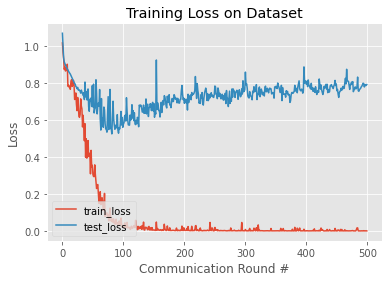

In [39]:
import matplotlib.pyplot as plt
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Communication Round #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH_LOSS)
# serialize the model to disk

**Accuracy**

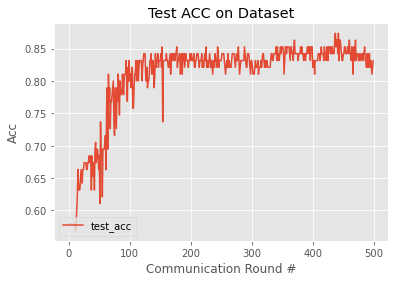

In [40]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["test_acc"], label="test_acc")
plt.title("Test ACC on Dataset")
plt.xlabel("Communication Round #")
plt.ylabel("Acc")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH_ACC)

**Save historical in a JSON file**

In [41]:
# load json module
import json



# create json object from dictionary
json = json.dumps(H)

# open file for writing, "w" 
f = open(PLOT_PATH_HIS,"w")

# write json object to file
f.write(json)

# close file
f.close()

### **Save Final Model**

In [42]:
if selected_method == "AVG":
  #Save general model
  H_avg=H
  torch.save(global_model, MODEL_PATH_glob)

if selected_method == "ENSEMBLE":
  H_ensemble=H
  #Save Ensemble Model Global
  torch.save(global_models_ensemble, MODEL_PATH_glob)
  #Save Model by Model
  model_number=0
  for model in global_models_ensemble:
    model_name="vgg16_"+str(model_number)+".pth"
    #print(model_name)
    MODEL_PATH_new = os.path.join(MODEL_PATH, model_name)
    torch.save(model, MODEL_PATH_new)
    model_number+=1

### **Save Global Parameters**

In [43]:
print("[INFO] saving Model Parameters...")
f = open(MODEL_PATH_param, "w")
f.write(str(Glob_Param))
f.close()

[INFO] saving Model Parameters...


### **Save Transformation**

In [44]:
print("[INFO] saving Model Transformation...")
f = open(MODEL_PATH_trans, "w")
f.write(str(train_transforms))
f.close()

[INFO] saving Model Transformation...


### **Save Best Model Round**

In [45]:
print("[INFO] saving Best Model Round...")
MODEL_PATH_best_round = os.path.join(MODEL_PATH, "best_model_round.txt")
f = open(MODEL_PATH_best_round, "w")
f.write(str(Best))
f.close()

[INFO] saving Best Model Round...


# 8. Predict Test Dataset to check Generalization Accuracy

### Load Model

In [46]:
loaded_model = torch.load(MODEL_PATH_glob, map_location=DEVICE)

### Functions to Predict

**Predict a Dataset**

In [47]:
def prediction_dataset(global_model, test_loader, method):
  if method == "ENSEMBLE":
    for model in global_model:
        model.eval()
  else:
    global_model.eval()

  pred_final=[]
  target_final=[]
  correct = 0
  confusion_matrix_torch = torch.zeros(num_classes, num_classes)
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                data = data.float()
                if method == "ENSEMBLE": 
                  global_output=[]
                  for model in global_model:
                    output_model = model(data)
                    global_output.append(output_model)
                  final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
                  pred = final_output[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()
                if method == "AVG":
                  output = global_model(data)
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()

                for t, p in zip(target.view(-1), pred.view(-1)):
                  confusion_matrix_torch[t.long(), p.long()] += 1
                pred_final.extend(pred.to('cpu').numpy().tolist())
                target_final.extend(target.to('cpu').numpy().tolist())

  acc = correct/len(test_loader.dataset)

  return target_final, pred_final, confusion_matrix_torch, acc

**Predict a simple Image**

In [48]:
def predict_image(global_model, image, method):
    if method == "ENSEMBLE":
      global_output=[]
      for model in global_model:
        model.eval()
        output_model = model(image)
        global_output.append(output_model)
      final_output=torch.mean(torch.stack([output.float() for output in global_output], 0),dim=0, keepdim=True)
      pred = final_output[0].argmax(dim=1, keepdim=True)
    
    if method == "AVG":
      global_model.eval()
      output_model = global_model(image)
      pred = output_model.argmax(dim=1, keepdim=True)
    
    return pred

### Precit Global Validation Dataset

In [49]:
target_final, pred_final, confusion_matrix_pred, acc = prediction_dataset(loaded_model, val_loader, selected_method)
print("Final Confusion Matrix: ")
print(confusion_matrix_pred)
print(acc)

Final Confusion Matrix: 
tensor([[46.,  4.,  6.],
        [ 7., 19.,  1.],
        [ 3.,  0., 10.]])
0.78125


**Get different metrics**

In [50]:
confusion_matrix_skl=confusion_matrix(target_final, pred_final)
F1_skl=f1_score(target_final, pred_final, average='micro')
recall_skl=recall_score(target_final, pred_final, average='micro')
precision_skl=precision_score(target_final, pred_final, average='micro')
precision_recall_fscore_skl=precision_recall_fscore_support(target_final, pred_final, average='micro')
print(classification_report(target_final, pred_final, target_names=classes))

              precision    recall  f1-score   support

      benign       0.82      0.82      0.82        56
   malignant       0.83      0.70      0.76        27
      normal       0.59      0.77      0.67        13

    accuracy                           0.78        96
   macro avg       0.75      0.76      0.75        96
weighted avg       0.79      0.78      0.78        96



### Precit Each Client Validation Dataset

In [56]:
if len(clients_list)>1:
  i=0
  for client in clients_list:
    print("Validation Accuracy Client: ", client)
    target_final, pred_final, confusion_matrix_pred, acc = prediction_dataset(loaded_model, val_loader_client[i], selected_method)
    print(confusion_matrix_pred)
    if client=="B":
      print(classification_report(target_final, pred_final, target_names=classes))
    else:
      print(classification_report(target_final, pred_final, target_names=classes))
    i+=1

Validation Accuracy Client:  A
tensor([[36.,  3.,  5.],
        [ 6., 15.,  0.],
        [ 3.,  0., 10.]])
              precision    recall  f1-score   support

      benign       0.80      0.82      0.81        44
   malignant       0.83      0.71      0.77        21
      normal       0.67      0.77      0.71        13

    accuracy                           0.78        78
   macro avg       0.77      0.77      0.76        78
weighted avg       0.79      0.78      0.78        78

Validation Accuracy Client:  B
tensor([[10.,  1.,  1.],
        [ 1.,  4.,  1.],
        [ 0.,  0.,  0.]])
              precision    recall  f1-score   support

      benign       0.91      0.83      0.87        12
   malignant       0.80      0.67      0.73         6
      normal       0.00      0.00      0.00         0

    accuracy                           0.78        18
   macro avg       0.57      0.50      0.53        18
weighted avg       0.87      0.78      0.82        18



/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 9. Plot Some Prediction Example

In [52]:
def prepare_plot(origImage, real_label, pred_label):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    # plot the original image, its mask, and the predicted mask
    ax.imshow(origImage, cmap="gray")
    # set the titles of the subplots
    ax.set_title("Image Label: %s; Predicated Label: %s" % (real_label,pred_label))
    
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [53]:
def make_predictions(model, imagePath, method):
    # set model to evaluation mode
    #model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (image_size, image_size))
        
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        real_name = filename.split(".")[0]
        type_file = filename.split(".")[1]
        #real_label = filename.split(" ")[0]
        real_label = (imagePath.split('/')[-2]) 
    

        ###########################################################
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        #image = np.transpose(image, (2, 1))
        
        image = np.expand_dims(image, 0)
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        
        pred_label = predict_image(model, image, method)

        pred_label=idx_to_class[pred_label.to('cpu').tolist()[0][0]]
        #print(orig.shape)
        #print(gtMask.shape)
        #print(predMask.shape)
        # prepare a plot for visualization
        prepare_plot(orig, real_label, pred_label)

[INFO] loading up test image paths...
['./Final Clinical Image/ds_all/images/test/normal/normal (125).png'
 './Final Clinical Image/ds_all/images/test/normal/normal (124).png'
 './Final Clinical Image/ds_all/images/test/benign/benign (145).png'
 './Final Clinical Image/ds_all/images/test/malignant/malignant (117).png'
 './Final Clinical Image/ds_all/images/test/malignant/malignant (85).png'
 './Final Clinical Image/ds_all/images/test/benign/benign (171).png'
 './Final Clinical Image/ds_all/images/test/malignant/malignant (187).png'
 './Final Clinical Image/ds_all/images/test/benign/benign (25).png'
 './Final Clinical Image/ds_all/images/test/malignant/000045.png'
 './Final Clinical Image/ds_all/images/test/benign/benign (244).png']
[INFO] load up model...


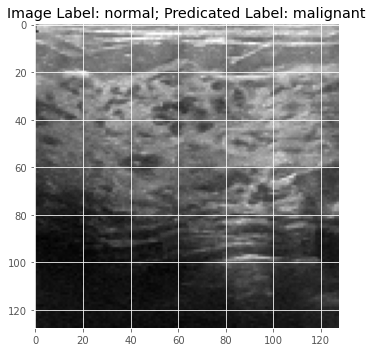

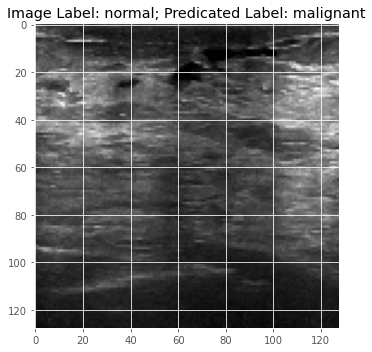

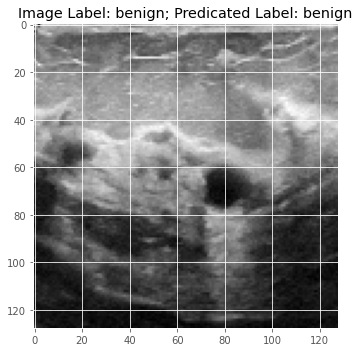

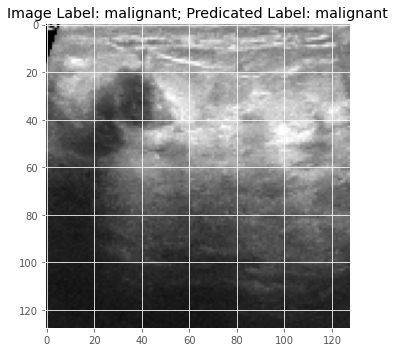

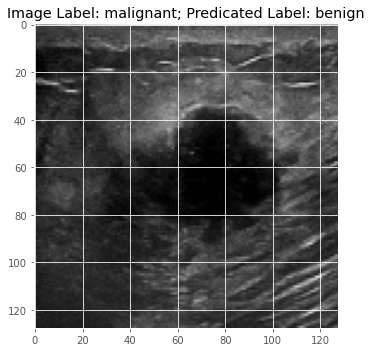

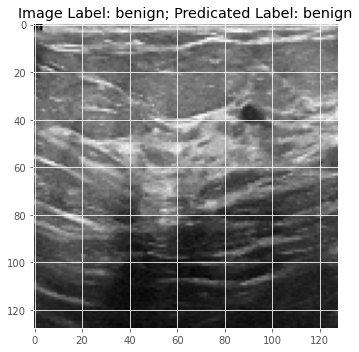

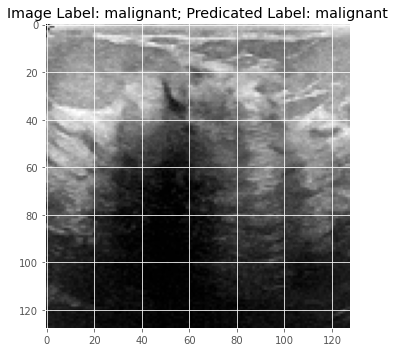

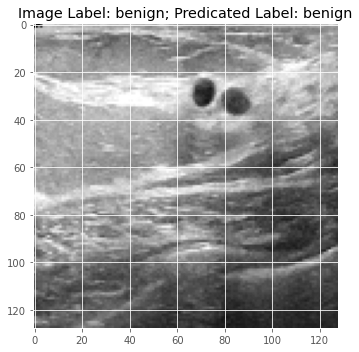

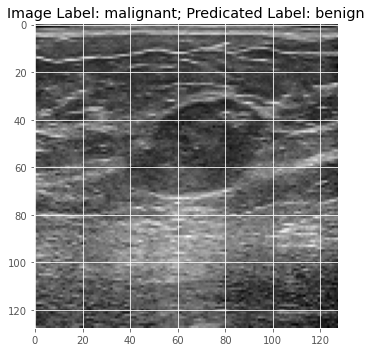

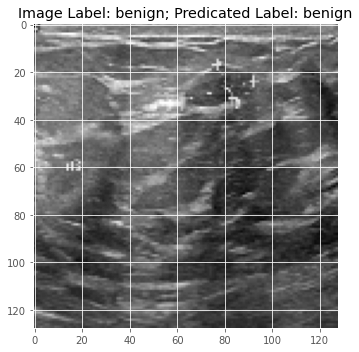

In [54]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
print(imagePaths)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(loaded_model, path, method=selected_method)

In [55]:
torch.cuda.empty_cache()